In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import os
import re

# Directories

In [2]:
ap_raw_dir = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\AP\Raw"
transect_meta = pd.read_csv(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\NESLTER_transect_metadata.csv")
log_path = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\LTER_sample_log.xlsx"

In [3]:
cruises = ['EN608', 'EN687', 'EN695', 'EN720', 
           'EN706', 'EN712', "EN661", "EN617"]

# AP Data Availability

In [4]:
# list files
ap_files = [f for f in os.listdir(ap_raw_dir) if f.endswith("_RawData.txt")]
ap_df = pd.DataFrame({"ap_filename": ap_files})
ap_df.head()

,ap_filename
0,AE2426_C01N02da_RawData.txt
1,AE2426_C01N02pa_RawData.txt
2,AE2426_C01N13da_RawData.txt
3,AE2426_C01N13pa_RawData.txt
4,AE2426_C04N04da_RawData.txt


In [5]:
# extract cruise, cast, niskin, type
m = ap_df["ap_filename"].str.extract(r"^([A-Za-z0-9]+)_C(\d+)N(\d+)([pd])([a-z])_RawData\.txt")
ap_df[["cruise","cast","niskin","type","rep"]] = m
ap_df["type"] = ap_df["type"].str.lower()
ap_df["rep"]  = ap_df["rep"].str.lower()
ap_df = ap_df.dropna()

# keep latest replicate per (cruise, cast, niskin, type)
ap_df["max_rep"] = ap_df.groupby(["cruise","cast","niskin","type"])["rep"].transform("max")
latest = ap_df[ap_df["rep"] == ap_df["max_rep"]]

# two lists (lowercase p and d only)
p_files = latest.loc[latest["type"] == "p", "ap_filename"].tolist()
d_files = latest.loc[latest["type"] == "d", "ap_filename"].tolist()

In [6]:
def keep_latest(files):
    latest = {}
    for f in files:
        m = re.match(r'^([A-Za-z0-9]+)_C(\d+)N(\d+)[pd]([a-z])_RawData\.txt$', f)
        if not m:
            continue
        key = (m.group(1), int(m.group(2)), int(m.group(3)))
        rep = m.group(4)
        prev = latest.get(key)
        if prev is None or rep > prev[0]:
            latest[key] = (rep, f)
    return [v[1] for v in latest.values()]

p_files_latest = keep_latest(p_files)
d_files_latest = keep_latest(d_files)

In [7]:
# build key tables from the two lists
def extract_keys(files, colname):
    rows = []
    for f in files:
        m = re.match(r'^([A-Za-z0-9]+)_C(\d+)N(\d+)[pd][a-z]_RawData\.txt$', f)
        if m:
            rows.append({
                "cruise": m.group(1),
                "cast": int(m.group(2)),
                "niskin": int(m.group(3)),
                colname: f
            })
    return pd.DataFrame(rows)

p_df = extract_keys(p_files_latest, "p_filename")
d_df = extract_keys(d_files_latest, "d_filename")

pairs = p_df.merge(d_df, on=["cruise","cast","niskin"], how="outer")
pairs.head()

,cruise,cast,niskin,p_filename,d_filename
0,AE2426,1,2,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt
1,AE2426,1,13,AE2426_C01N13pa_RawData.txt,AE2426_C01N13da_RawData.txt
2,AE2426,4,4,AE2426_C04N04pa_RawData.txt,AE2426_C04N04da_RawData.txt
3,AE2426,4,10,AE2426_C04N10pa_RawData.txt,AE2426_C04N10da_RawData.txt
4,AE2426,4,16,AE2426_C04N16pa_RawData.txt,AE2426_C04N16da_RawData.txt


In [8]:
# keep only rows where both p and d exist
pairs_df = (
    pairs.dropna(subset=["p_filename", "d_filename"])
         .loc[:, ["cruise", "cast", "niskin", "p_filename", "d_filename"]]
         .reset_index(drop=True)
)

## Files without pa and da

In [9]:
# rows where one side is missing
mismatches = pairs[pairs["p_filename"].isna() | pairs["d_filename"].isna()].copy()
missing_p = mismatches[mismatches["p_filename"].isna()][["cruise","cast","niskin","d_filename"]]
missing_d = mismatches[mismatches["d_filename"].isna()][["cruise","cast","niskin","p_filename"]]

print("Total keys:", len(pairs))
print("Mismatches:", len(mismatches))
print("Missing p:", len(missing_p), "| Missing d:", len(missing_d))
mismatches

Total keys: 323
Mismatches: 1
Missing p: 0 | Missing d: 1


,cruise,cast,niskin,p_filename,d_filename
226,EN706,20,11,EN706_C20N11pa_RawData.txt,NaN


# Add AP Metadata

In [11]:
# Load LTER sample log (sheet named "Sample_log")
log_df = pd.read_excel(log_path, sheet_name="Sample_log")

# make sure cast and niskin are numeric for matching
log_df["Cast"] = pd.to_numeric(log_df["Cast"], errors="coerce")
log_df["Niskin #"] = pd.to_numeric(log_df["Niskin #"], errors="coerce")

# standardize cruise text (upper case to match your ap_df["cruise"])
log_df["Cruise"] = log_df["Cruise"].astype(str).str.strip().str.upper()
pairs_df["cruise"] = pairs_df["cruise"].astype(str).str.strip().str.upper()


In [12]:
# merge and keep only cruise, cast, niskin, filename, and AP vol
merged_df = pairs_df.merge(
    log_df[["Cruise", "Cast", "Niskin #", "Ap vol", "LTER Station", "Niskin Target Depth", "Date (UTC)"]],
    left_on=["cruise", "cast", "niskin"],
    right_on=["Cruise", "Cast", "Niskin #"],
    how="left"
)

# drop redundant columns
merged_df = merged_df.drop(columns=["Cruise", "Cast", "Niskin #"])

# rename AP vol to Ap_vol
merged_df = merged_df.rename(columns={"Ap vol": "Ap_vol", "LTER Station": "station", "Niskin Target Depth": "depth", "Date (UTC)":"date_UTC"})

In [13]:
def normalize_station(val):
    if pd.isna(val):
        return val
    s = str(val).strip()
    if s.lower() == "mvco":
        return "MVCO"
    m = re.match(r"^L?\s*0*(\d+)$", s, flags=re.IGNORECASE)  # matches "7", "07", "L7", "l07"
    if m:
        return f"L{int(m.group(1))}"  # drop leading zeros
    return s  # leave other forms unchanged

# overwrite in place and also mirror to a lowercase-friendly column if you want
merged_df["station"] = merged_df["station"].apply(normalize_station)
merged_df

,cruise,cast,niskin,p_filename,d_filename,Ap_vol,station,depth,date_UTC
0,AE2426,1,2,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt,537,L1,17,20241106.0
1,AE2426,1,13,AE2426_C01N13pa_RawData.txt,AE2426_C01N13da_RawData.txt,547,L1,3,20241106.0
2,AE2426,4,4,AE2426_C04N04pa_RawData.txt,AE2426_C04N04da_RawData.txt,547,L2,27,20241107.0
3,AE2426,4,10,AE2426_C04N10pa_RawData.txt,AE2426_C04N10da_RawData.txt,549,L2,15,20241107.0
4,AE2426,4,16,AE2426_C04N16pa_RawData.txt,AE2426_C04N16da_RawData.txt,540,L2,2,20241107.0
...,...,...,...,...,...,...,...,...,...
317,EN720,20,9,EN720_C20N09pa_RawData.txt,EN720_C20N09db_RawData.txt,547,L3,34,20240910.0
318,EN720,20,20,EN720_C20N20pa_RawData.txt,EN720_C20N20da_RawData.txt,548,L3,4,20240910.0
319,EN720,24,2,EN720_C24N02pb_RawData.txt,EN720_C24N02db_RawData.txt,532,MVCO,15,20240911.0
320,EN720,24,4,EN720_C24N04pa_RawData.txt,EN720_C24N04da_RawData.txt,547,MVCO,8,20240911.0


In [14]:
# Split into clean rows (no NaNs anywhere) and rows that contain at least one NaN
nan_mask = merged_df.isna().any(axis=1)
ap_clean_df   = merged_df[~nan_mask].copy()  # rows without NaNs

## Unprocessed AP casts/niskins

In [15]:
unmatched_df = log_df[~log_df.set_index(["Cruise", "Cast", "Niskin #"]).index
                      .isin(pairs_df.set_index(["cruise", "cast", "niskin"]).index)].copy()

# Keep only relevant columns
unmatched_df = unmatched_df[["Cruise", "Cast", "Niskin #", "Ap vol", "LTER Station", "Niskin Target Depth", "Date (UTC)"]]
unmatched_df = unmatched_df.rename(columns={
    "Ap vol": "Ap_vol",
    "LTER Station": "station",
    "Niskin Target Depth": "depth",
    "Date (UTC)": "date_UTC"
})

# Drop rows with '-' in Ap_vol
unmatched_df = unmatched_df[~unmatched_df["Ap_vol"].astype(str).str.contains("-", na=False)].copy()

# Keep only cruises that exist in merged_df
unmatched_df = unmatched_df[unmatched_df["Cruise"].isin(merged_df["cruise"].unique())].copy()

# Reset index for clarity
unmatched_df = unmatched_df.reset_index(drop=True)

print(f"Remaining unprocessed samples: {len(unmatched_df)}")
#unmatched_df

Remaining unprocessed samples: 19


## Missing AP Volume Filtered

In [16]:
ap_missing_df = merged_df[nan_mask].copy()   # rows with any NaN
print("Clean rows:", ap_clean_df.shape[0], "| Rows with NaNs:", ap_missing_df.shape[0])
#ap_missing_df

Clean rows: 321 | Rows with NaNs: 1


In [17]:
missing_ap = pd.concat([unmatched_df, ap_missing_df], axis=0, ignore_index = True)
missing_ap

,Cruise,Cast,Niskin #,Ap_vol,station,depth,date_UTC,cruise,cast,niskin,p_filename,d_filename
0,AR28B,12.0,15.0,1060,11,23,20180410.0,NaN,NaN,NaN,NaN,NaN
1,AR28B,12.0,19.0,1057,11,3,20180410.0,NaN,NaN,NaN,NaN,NaN
2,AR61B,1.0,3.0,547,L1,12,20211108.0,NaN,NaN,NaN,NaN,NaN
3,AR61B,1.0,6.0,548,L1,3,20211108.0,NaN,NaN,NaN,NaN,NaN
4,AR61B,2.0,8.0,547,L2,17,20211108.0,NaN,NaN,NaN,NaN,NaN
5,AR61B,2.0,12.0,538,L2,3,20211108.0,NaN,NaN,NaN,NaN,NaN
6,AR61B,3.0,9.0,547,L3,17,20211108.0,NaN,NaN,NaN,NaN,NaN
7,AR61B,3.0,11.0,548,L3,3,20211108.0,NaN,NaN,NaN,NaN,NaN
8,AR61B,4.0,12.0,547,L4,24,20211109.0,NaN,NaN,NaN,NaN,NaN
9,AR61B,6.0,7.0,547,L5,45,20211109.0,NaN,NaN,NaN,NaN,NaN


In [18]:
out_ap_path = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\AP\unprocessed_ap.csv"
missing_ap.to_csv(out_ap_path, index=False)
print("Exported to:", out_ap_path)

Exported to: C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\AP\unprocessed_ap.csv


# Add Lat Lon Metadata

In [19]:
transect_meta = transect_meta[transect_meta["cast"].apply(lambda x: str(x).isdigit())]
transect_meta["cast"] = transect_meta["cast"].astype(int)
transect_meta.columns

Index(['dataset', 'pid', 'sample_time', 'ifcb', 'ml_analyzed', 'latitude',
       'longitude', 'depth', 'cruise', 'cast', 'niskin', 'sample_type',
       'n_images', 'tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'comment_summary',
       'trigger_selection', 'skip'],
      dtype='object')

In [20]:
# Make sure cast/niskin/cruise line up in both dfs
transect_meta = transect_meta.copy()

transect_meta["cruise"] = (
    transect_meta["cruise"]
    .astype(str)
    .str.strip()
    .str.upper()
)
transect_meta["cast"] = pd.to_numeric(transect_meta["cast"], errors="coerce").astype("Int64")
transect_meta["niskin"] = pd.to_numeric(transect_meta["niskin"], errors="coerce").astype("Int64")

ap_clean_df = ap_clean_df.copy()
ap_clean_df["cruise"] = (
    ap_clean_df["cruise"]
    .astype(str)
    .str.strip()
    .str.upper()
)
ap_clean_df["cast"] = pd.to_numeric(ap_clean_df["cast"], errors="coerce").astype("Int64")
ap_clean_df["niskin"] = pd.to_numeric(ap_clean_df["niskin"], errors="coerce").astype("Int64")


In [21]:
meta_cols = [
    "cruise", "cast", "niskin",
    "latitude", "longitude",
]

merged_df2 = ap_clean_df.merge(
    transect_meta[meta_cols],
    on=["cruise", "cast", "niskin"],
    how="left",
    suffixes=("", "_meta")
)

merged_df2 = merged_df2.rename(columns={
    "latitude": "Lat",
    "longitude": "Lon"
})

C:\Users\ocron\AppData\Local\Temp\ipykernel_37796\2554168093.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(stations))


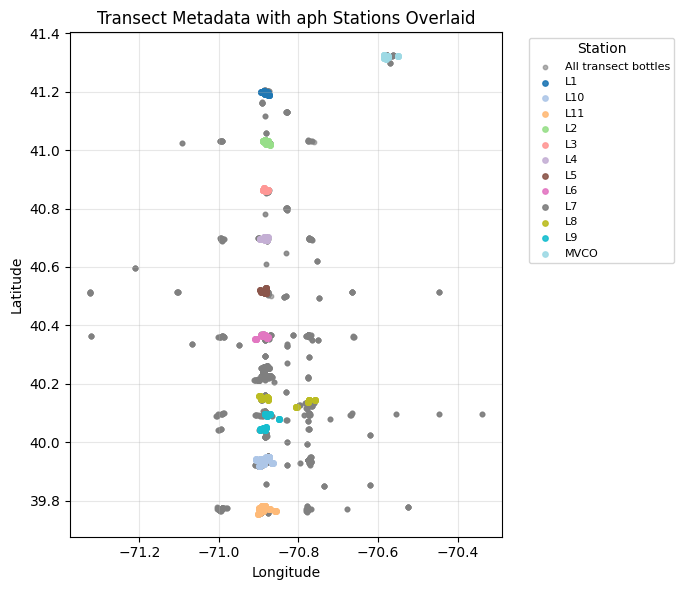

In [22]:
# Build station list and colors for the aph subset
stations = sorted(merged_df2["station"].dropna().unique())
cmap = plt.cm.get_cmap("tab20", len(stations))
station_colors = {st: cmap(i) for i, st in enumerate(stations)}

plt.figure(figsize=(7,6))

# all transect_meta locations (light grey)
plt.scatter(
    transect_meta["longitude"],
    transect_meta["latitude"],
    s=10,
    color="grey",
    alpha=0.6,
    label="All transect bottles"
)

# aph stations, color by station
for st, sub in merged_df2.groupby("station"):
    plt.scatter(
        sub["Lon"],        # from your merged aph/out df
        sub["Lat"],
        s=15,
        alpha=0.9,
        color=station_colors[st],
        label=str(st)
    )

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Transect Metadata with aph Stations Overlaid")
plt.legend(
    title="Station",
    fontsize=8,
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
#overall aph availability
aph_base = pairs_df[["cruise","cast","niskin"]].drop_duplicates().copy()

# standardize
aph_base["cruise"] = aph_base["cruise"].astype(str).str.upper().str.strip()
aph_base["cast"]   = pd.to_numeric(aph_base["cast"], errors="coerce").astype("Int64")
aph_base["niskin"] = pd.to_numeric(aph_base["niskin"], errors="coerce").astype("Int64")

aph_base["has_aph"] = True

# Export Data

In [24]:
out_path = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\AP\ap_VolFilt.csv"
merged_df2.to_csv(out_path, index=False)

print("Exported to:", out_path)

Exported to: C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\AP\ap_VolFilt.csv


In [25]:
merged_df2.columns

Index(['cruise', 'cast', 'niskin', 'p_filename', 'd_filename', 'Ap_vol',
       'station', 'depth', 'date_UTC', 'Lat', 'Lon'],
      dtype='object')

# IFCB Data Availability

In [26]:
# start from transect_meta
ifcb_keys = transect_meta[["cruise", "cast", "niskin", "ifcb"]].copy()

# standardize keys
ifcb_keys["cruise"] = ifcb_keys["cruise"].astype(str).str.upper().str.strip()
ifcb_keys["cast"]   = pd.to_numeric(ifcb_keys["cast"], errors="coerce").astype("Int64")
ifcb_keys["niskin"] = pd.to_numeric(ifcb_keys["niskin"], errors="coerce").astype("Int64")

# filter to cruises of interest
ifcb_keys = ifcb_keys[ifcb_keys["cruise"].isin(cruises)]

# define IFCB presence
ifcb_keys["has_ifcb"] = (
    ifcb_keys["ifcb"].notna() &
    (ifcb_keys["ifcb"].astype(str).str.strip() != "")
)

# reduce to unique bottle keys
ifcb_keys = ifcb_keys[["cruise", "cast", "niskin", "has_ifcb"]].drop_duplicates()
ifcb_keys

,cruise,cast,niskin,has_ifcb
5022,EN608,1,19,True
5029,EN608,1,5,True
5050,EN608,3,3,True
5058,EN608,4,12,True
5064,EN608,4,4,True
...,...,...,...,...
25255,EN720,20,1,True
25256,EN720,20,5,True
25290,EN720,24,7,True
25291,EN720,24,4,True


# Attune Availability

In [27]:
ATTUNE_ROOT = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Attune"

def load_attune_keys_from_summary(cruise_list):
    frames = []
    for cruise in cruise_list:
        fp = os.path.join(ATTUNE_ROOT, f"{cruise}", "SummaryTable.csv")
        if not os.path.exists(fp):
            print(f"[Attune] missing SummaryTable: {fp}")
            continue

        st = pd.read_csv(fp, encoding="latin-1")

        # standardize keys
        st["cruise"] = st["cruise"].astype(str).str.upper().str.strip()
        st["cast"]   = pd.to_numeric(st["Cast"], errors="coerce").astype("Int64")
        st["niskin"] = pd.to_numeric(st["Niskin"], errors="coerce").astype("Int64")

        keys = st[["cruise", "cast", "niskin"]].dropna().drop_duplicates()
        keys["has_attune"] = True
        frames.append(keys)

    if not frames:
        return pd.DataFrame(columns=["cruise", "cast", "niskin", "has_attune"])

    out = pd.concat(frames, ignore_index=True).drop_duplicates()
    return out


In [28]:
attune_keys = load_attune_keys_from_summary(cruises)
attune_keys

[Attune] missing SummaryTable: C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Attune\EN687\SummaryTable.csv


,cruise,cast,niskin,has_attune
0,EN608,1,2,True
1,EN608,1,5,True
2,EN608,1,9,True
3,EN608,1,19,True
4,EN608,4,1,True
...,...,...,...,...
472,EN617,21,16,True
473,EN617,21,20,True
474,EN617,35,2,True
475,EN617,35,4,True


# Depth

In [29]:
DEPTH_PATH = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Depth\depth_partitioning2.csv"

depth_df = pd.read_csv(DEPTH_PATH)

# standardize keys
depth_df["cruise"] = depth_df["cruise"].astype(str).str.upper().str.strip()
depth_df["cast"]   = pd.to_numeric(depth_df["cast"], errors="coerce").astype("Int64")
depth_df["niskin"] = pd.to_numeric(depth_df["niskin"], errors="coerce").astype("Int64")

depth_df["depth_cat"] = depth_df["depth_cat"].astype(str).str.strip()


# Merge all to assess availability

In [30]:
# ============================================================
# Base: aph samples (paired p + d already enforced in aph_base)
# ============================================================

aph_ifcb = aph_base.merge(
    ifcb_keys,   # has_ifcb
    on=["cruise", "cast", "niskin"],
    how="left"
)
aph_ifcb["has_ifcb"] = aph_ifcb["has_ifcb"].fillna(False)


# ============================================================
# Merge Attune
# ============================================================

aph_ifcb_att = aph_ifcb.merge(
    attune_keys,   # has_attune
    on=["cruise", "cast", "niskin"],
    how="left"
)
aph_ifcb_att["has_attune"] = aph_ifcb_att["has_attune"].fillna(False)


# ============================================================
# Merge depth categories (authoritative)
# ============================================================

aph_ifcb_att = aph_ifcb_att.merge(
    depth_df[["cruise","cast","niskin","depth_cat"]],
    on=["cruise", "cast", "niskin"],
    how="left"
)


# ============================================================
# Merge station ONCE so it propagates everywhere
# ============================================================

station_lookup = merged_df2[
    ["cruise","cast","niskin","station"]
].drop_duplicates().copy()

station_lookup["cruise"] = station_lookup["cruise"].astype(str).str.upper().str.strip()
station_lookup["cast"]   = pd.to_numeric(station_lookup["cast"], errors="coerce").astype("Int64")
station_lookup["niskin"] = pd.to_numeric(station_lookup["niskin"], errors="coerce").astype("Int64")

aph_ifcb_att = aph_ifcb_att.merge(
    station_lookup,
    on=["cruise","cast","niskin"],
    how="left"
)


C:\Users\ocron\AppData\Local\Temp\ipykernel_37796\2679206350.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aph_ifcb["has_ifcb"] = aph_ifcb["has_ifcb"].fillna(False)
C:\Users\ocron\AppData\Local\Temp\ipykernel_37796\2679206350.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aph_ifcb_att["has_attune"] = aph_ifcb_att["has_attune"].fillna(False)


In [31]:
aph_ifcb_att_sd = aph_ifcb_att[
    aph_ifcb_att["depth_cat"].isin(["Surface", "DCM"])
].copy()

print("APH Surface+DCM bottles:", len(aph_ifcb_att_sd))
print("APH+IFCB Surface+DCM:", aph_ifcb_att_sd["has_ifcb"].sum())
print(
    "APH+IFCB+Attune Surface+DCM:",
    ((aph_ifcb_att_sd["has_ifcb"]) & (aph_ifcb_att_sd["has_attune"])).sum()
)


APH Surface+DCM bottles: 247
APH+IFCB Surface+DCM: 170
APH+IFCB+Attune Surface+DCM: 144


In [32]:
aph_ifcb_no_attune_sd = aph_ifcb_att_sd[
    (aph_ifcb_att_sd["has_ifcb"]) &
    (~aph_ifcb_att_sd["has_attune"])
].copy()

print("APH+IFCB but no Attune (Surface+DCM):", len(aph_ifcb_no_attune_sd))
print(
    aph_ifcb_no_attune_sd
    .groupby(["cruise","depth_cat"])
    .size()
)


APH+IFCB but no Attune (Surface+DCM): 26
cruise  depth_cat
EN687   DCM          12
        Surface      12
EN712   DCM           1
        Surface       1
dtype: int64


In [33]:
aph_attune_no_ifcb_sd = aph_ifcb_att_sd[
    (aph_ifcb_att_sd["has_attune"]) &
    (~aph_ifcb_att_sd["has_ifcb"])
].copy()

print("APH+Attune but no IFCB (Surface+DCM):", len(aph_attune_no_ifcb_sd))

aph_attune_no_ifcb_sd[
    ["cruise","cast","niskin","station","depth_cat"]
].sort_values(
    ["cruise","depth_cat","cast","niskin"]
)


APH+Attune but no IFCB (Surface+DCM): 5


,cruise,cast,niskin,station,depth_cat
69,EN608,9,9,L5,DCM
86,EN608,30,1,MVCO,DCM
194,EN695,10,4,L3,DCM
212,EN706,9,19,L11,Surface
238,EN712,6,16,L7,Surface


In [ ]:
casts_of_interest = aph_attune_no_ifcb_sd[
    ["cruise","cast"]
].drop_duplicates()


In [34]:
depth_check = depth_df.copy()
depth_check["cruise"] = depth_check["cruise"].astype(str).str.upper().str.strip()
depth_check["cast"]   = pd.to_numeric(depth_check["cast"], errors="coerce").astype("Int64")
depth_check["niskin"] = pd.to_numeric(depth_check["niskin"], errors="coerce").astype("Int64")

others_in_same_cast = (
    depth_check
    .merge(casts_of_interest, on=["cruise","cast"], how="inner")
    .query("depth_cat == 'Other'")
    .sort_values(["cruise","cast","niskin"])
)

others_in_same_cast[["cruise","cast","niskin","depth_cat"]]


,cruise,cast,niskin,depth_cat
3,EN608,30,5,Other
10,EN706,9,15,Other
12,EN712,6,3,Other


In [35]:
ifcb_lookup = transect_meta[
    ["cruise","cast","niskin","ifcb"]
].copy()

ifcb_lookup["cruise"] = ifcb_lookup["cruise"].astype(str).str.upper().str.strip()
ifcb_lookup["cast"]   = pd.to_numeric(ifcb_lookup["cast"], errors="coerce").astype("Int64")
ifcb_lookup["niskin"] = pd.to_numeric(ifcb_lookup["niskin"], errors="coerce").astype("Int64")

ifcb_lookup["has_ifcb"] = (
    ifcb_lookup["ifcb"].notna() &
    (ifcb_lookup["ifcb"].astype(str).str.strip() != "")
)

others_with_ifcb = others_in_same_cast.merge(
    ifcb_lookup[["cruise","cast","niskin","has_ifcb"]],
    on=["cruise","cast","niskin"],
    how="left"
)

others_with_ifcb["has_ifcb"] = others_with_ifcb["has_ifcb"].fillna(False)
others_with_ifcb = others_with_ifcb.drop_duplicates(
    subset=["cruise","cast","niskin"]
)

others_with_ifcb = others_with_ifcb.merge(
    station_lookup,
    on=["cruise","cast","niskin"],
    how="left"
)


C:\Users\ocron\AppData\Local\Temp\ipykernel_63452\501585403.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  others_with_ifcb["has_ifcb"] = others_with_ifcb["has_ifcb"].fillna(False)


In [36]:
others_with_ifcb_true = others_with_ifcb[
    others_with_ifcb["has_ifcb"]
][
    ["cruise","cast","niskin","station","depth_cat","has_ifcb"]
]

others_with_ifcb_true


,cruise,cast,niskin,station,depth_cat,has_ifcb


In [37]:
ref = aph_ifcb_att_sd[[
    "cruise",
    "cast",
    "niskin",
    "station",
    "depth_cat",
    "has_aph",
    "has_ifcb",
    "has_attune"
]].drop_duplicates().copy()

# enforce clean types
ref["cruise"] = ref["cruise"].astype(str).str.upper().str.strip()
ref["cast"]   = pd.to_numeric(ref["cast"], errors="coerce").astype("Int64")
ref["niskin"] = pd.to_numeric(ref["niskin"], errors="coerce").astype("Int64")

for c in ["has_aph","has_ifcb","has_attune"]:
    ref[c] = ref[c].astype(bool)

print("Availability reference shape:", ref.shape)
print(ref.head())


Availability reference shape: (247, 8)
   cruise  cast  niskin station depth_cat  has_aph  has_ifcb  has_attune
0  AE2426     1       2      L1       DCM     True     False       False
1  AE2426     1      13      L1   Surface     True     False       False
2  AE2426     4       4      L2       DCM     True     False       False
4  AE2426     4      16      L2   Surface     True     False       False
5  AE2426     5       7      L5       DCM     True     False       False


In [38]:
OUT_REF = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\availability_reference.csv"
ref.to_csv(OUT_REF, index=False)